In [9]:
import torch
import cv2
import time
import os
import os.path as osp
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
from argparse import ArgumentParser
from collections import OrderedDict
from IoUEval import IoUEval
from Models import joint_model as net
import scipy.io as sio

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [27]:
x = torch.tensor([1.,2.,3.])
y = torch.tensor([4.,5.,6.])
z = torch.tensor([x.data])
# z = torch.unsqueeze(torch.cat((x,y)),1)
print(x.shape, z.shape)
print(z)

ValueError: only one element tensors can be converted to Python scalars

In [2]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse
import os
import torchvision.transforms as transforms
from PIL import Image
from Models.res2net import res2net101_v1b_26w_4s
import torch.utils.data as data
# !pip install torchsummary
from torchsummary import summary

In [8]:
from Models import single_model as net

m1 = net.JCS().to('cuda')
print(m1)

JCS(
  (vgg16): VGG16BN(
    (conv1_1): ConvBNReLU(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): FrozenBatchNorm2d(64)
      (act): ReLU(inplace=True)
    )
    (conv1_2): ConvBNReLU(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): FrozenBatchNorm2d(64)
      (act): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): ConvBNReLU(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): FrozenBatchNorm2d(128)
      (act): ReLU(inplace=True)
    )
    (conv2_2): ConvBNReLU(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): FrozenBatchNorm2d(128)
      (act): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): ConvBNReLU(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), s

In [78]:
model = res2net101_v1b_26w_4s(pretrained=False)
model.fc = torch.nn.Linear(2048, 2, bias=False)
model.to('cuda')

Res2Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): FrozenBatchNorm2d(32)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): FrozenBatchNorm2d(32)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): FrozenBatchNorm2d(64)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottle2neck(
      (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(104)
      (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (convs): ModuleList(
        (0): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(2

In [79]:
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
 FrozenBatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
 FrozenBatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 64, 256, 256]          18,432
 FrozenBatchNorm2d-8         [-1, 64, 256, 256]             128
              ReLU-9         [-1, 64, 256, 256]               0
        MaxPool2d-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 104, 128, 128]           6,656
FrozenBatchNorm2d-12        [-1, 104, 128, 128]             208
             ReLU-13        [-1, 104, 128, 128]               0
           Conv2d-14         [-1, 26, 1

# Dataset

In [80]:
DATA_DIR = './data/IDRID/B. Disease Grading'

In [81]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [82]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import cv2
import os.path as osp
import torch.utils.data
import pandas as pd

def scaleRadius(img, scale) :
    x=img[int(img.shape[0]/2),:,:].sum(1)
#     print(x)
    r=(x>x.mean()/10).sum()/2
    s=scale * 1.0 / r
#     print(r, s)
    return cv2.resize(img,(0,0), fx=s, fy=s), r, s

def scaleRadius_mask(img, scale, r, s) :
    x=img[int(img.shape[0]/2),:,:].sum(1)
#     print(x)
#     r=(x>x.mean()/10).sum()/2
#     s=scale * 1.0 / r
#     print(r, s)
    img = cv2.resize(img,(0,0), fx=s, fy=s)
    img[img > 0] = 255
    return img


class Dataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, data_dir=None, file_dir=None, dataset='train', grading_file_name=None, transform=None):
        self.transform = transform
        self.img_list = list()
        self.msk_list = list()
        self.label_list = list()
        self.all_mask_list = list()
        self.dataset_name = 'IDRID'
        self.grading_file_name = grading_file_name
        
        grading_df = pd.read_csv(self.grading_file_name)
        
        for idx, row in grading_df.iterrows():
#             print(row[0], row[1])
            img_name = osp.join(data_dir, str(row[0])+'.jpg')
            label_name = row[1]
            self.img_list.append(img_name)
            self.label_list.append(label_name)
            
        
        # grading part
        
        
#         self.classes = ['MA', 'HE', 'EX', 'SE']
#         with open(osp.join(file_dir, dataset + '_sg.txt'), 'r') as lines:
#             for line in lines:
#                 if dataset_name == 'IDRID':
#                     line_arr = line.split(',')
#                     self.img_list.append(osp.join(data_dir, line_arr[0].strip()))
#                     self.msk_list.append(osp.join(data_dir, line_arr[1].strip()))
                    
#                 elif dataset_name == 'FGADR':
# #                     print('coming here')
#                     line_arr = line.split(',')
                    
#                     self.img_list.append(line_arr[0].strip())
#                     self.msk_list.append(line_arr[1].strip())
                
                    
                    
#                 else:
#                     line_arr = line.split()

#                     self.img_list.append(osp.join(data_dir, line_arr[0].strip()))
#                     self.msk_list.append(osp.join(data_dir, line_arr[1].strip()))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        
        scale = 500
        image = cv2.imread(self.img_list[idx])
        
#         image, r, s = scaleRadius(image, scale)
#         image=cv2.addWeighted (image , 4 , cv2.GaussianBlur( image , ( 0 , 0 ) , scale /30) , -4 , 128)
#         print(image.shape, self.img_list[idx])
        
#         label1 = cv2.imread(self.msk_list[idx])
#         label = scaleRadius_mask(label1, scale, r, s)
#         label = label[:, :, 2]
        
        label = self.label_list[idx]


        if self.transform:
            [image, image_copy] = self.transform(image, image)
#         print(image.shape)
        return image, label
    

    def get_img_info(self, idx):
        image = cv2.imread(self.img_list[idx])
        return {"height": image.shape[0], "width": image.shape[1]}


In [64]:
data_dir_path = './data/IDRID/B. Disease Grading/1. Original Images/a. Training Set'
file_dir = './data/IDRID/'
batch_size = 4

training_grading_file = './data/IDRID/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
testing_grading_file = './data/IDRID/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Testing Labels.csv'
# since we training from scratch, we create data loaders at different scales
# so that we can generate more augmented data and prevent the network from overfitting
train_data = Dataset(data_dir_path, file_dir, 'train', grading_file_name=training_grading_file, transform=None)
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False, drop_last=True)
for datas in train_loader:
    img, lbl = datas
    print(img.shape, lbl)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/haal02/projects/env-ss/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/haal02/projects/env-ss/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/haal02/projects/env-ss/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 83, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/haal02/projects/env-ss/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 83, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/haal02/projects/env-ss/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 63, in default_collate
    return default_collate([torch.as_tensor(b) for b in batch])
  File "/home/haal02/projects/env-ss/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [816, 1228, 3] at entry 0 and [823, 1239, 3] at entry 1


In [83]:
import Transforms as myTransforms
width = 512
height = 512

NORMALISE_PARAMS = [np.array([0.406, 0.456, 0.485], dtype=np.float32).reshape((1, 1, 3)), # MEAN
                        np.array([0.225, 0.224, 0.229], dtype=np.float32).reshape((1, 1, 3))] # STD

# compose the data with transforms
trainDataset_main = myTransforms.Compose([
    myTransforms.Normalize(*NORMALISE_PARAMS),
    myTransforms.Scale(width, height),
    myTransforms.RandomCropResize(int(7./224*width)),
    myTransforms.RandomFlip(),
    #myTransforms.GaussianNoise(),
    myTransforms.ToTensor()
])


valDataset = myTransforms.Compose([
    myTransforms.Normalize(*NORMALISE_PARAMS),
    myTransforms.Scale(width, height),
    myTransforms.ToTensor()
])

# since we training from scratch, we create data loaders at different scales
# so that we can generate more augmented data and prevent the network from overfitting

data_dir_path = './data/IDRID/B. Disease Grading/1. Original Images/a. Training Set'
file_dir = './data/IDRID/'
batch_size = 4

training_grading_file = './data/IDRID/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
testing_grading_file = './data/IDRID/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Testing Labels.csv'
# since we training from scratch, we create data loaders at different scales
# so that we can generate more augmented data and prevent the network from overfitting

train_data = Dataset(data_dir_path, file_dir, 'train', grading_file_name=training_grading_file, transform=trainDataset_main)
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False, drop_last=True)


# train_data = Dataset(data_dir_path, file_dir, 'train', transform=trainDataset_main)
# test_data = Dataset(data_dir_path, file_dir, 'test', transform=valDataset)
# train_loader = torch.utils.data.DataLoader(train_data,
#     batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False, drop_last=True)

# valid_loader = torch.utils.data.DataLoader(test_data,
#     batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False, drop_last=True)

In [84]:
len(train_data)

413

In [85]:
# for datas in train_loader:
#     img, lbl = datas
#     print(img.shape)

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, scheduler=None):
#     losses = AverageMeter()
#     acc1s = AverageMeter()
#     acc5s = AverageMeter()

    model.train()

    for i, (input, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        input = input.cuda()
        target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        losses.update(loss.item(), input.size(0))
        acc1s.update(acc1.item(), input.size(0))
        acc5s.update(acc5.item(), input.size(0))

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    log = OrderedDict([
        ('loss', losses.avg),
        ('acc1', acc1s.avg),
        ('acc5', acc5s.avg),
    ])

    return log


def validate(args, val_loader, model, criterion):
    losses = AverageMeter()
    acc1s = AverageMeter()
    acc5s = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (input, target) in tqdm(enumerate(val_loader), total=len(val_loader)):
            input = input.cuda()
            target = target.cuda()

            output = model(input)
            loss = criterion(output, target)

            acc1, acc5 = accuracy(output, target, topk=(1, 5))

            losses.update(loss.item(), input.size(0))
            acc1s.update(acc1.item(), input.size(0))
            acc5s.update(acc5.item(), input.size(0))

    log = OrderedDict([
        ('loss', losses.avg),
        ('acc1', acc1s.avg),
        ('acc5', acc5s.avg),
    ])

    return log

In [ ]:
train(train_loader, model, criterion, optimizer, epoch, scheduler=None)
optimizer = 

In [8]:
for data in train_loader:
    img, mask = data
    
    img = img.to('cuda')
    out = model(img)
    print(out[0])
    break

tensor([ 7931427.5000, -6720970.5000], device='cuda:0',
       grad_fn=<SelectBackward>)


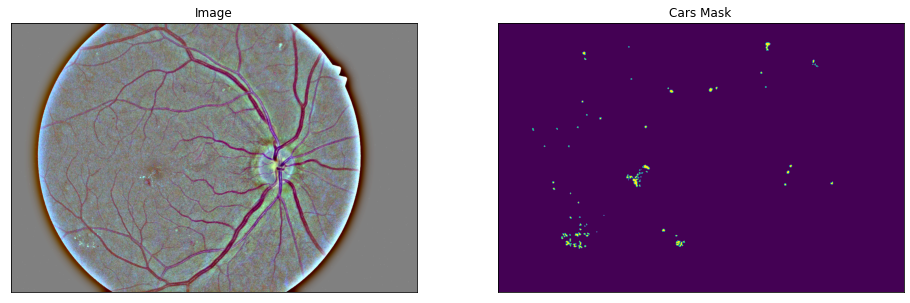

In [40]:
image, mask = train_data[0]
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [14]:
out[4].shape

torch.Size([4, 2048, 16, 16])